# Deploy del ensamble de los modelos
## Edgar Sabán - 19012631

In [32]:
# Carga de librerías
import numpy as np
import pandas as pd
import tensorflow as tf
from joblib import load
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [107]:
# Obteniendo los bestModels
tree = load("models/modelDecisionTreeClassifier(max_depth=3).joblib")
svm = load("models/modelSVM(C=2,kernel=rbf).joblib")
nb = load("models/modelNaiveBayes(sinVariable=EmbarkedS).joblib")
lr = load("models/modelLogisticRegression(lr=0.01,regularization=lasso,epochs=1000,bachSize=32).joblib")

In [108]:
# Obteniendo los datos de test
xTest = load("data/xTest.joblib")
xTest = xTest.drop(columns=['passenger_survived','survivedP'])
yTest = load("data/yTest.joblib")

Probabilidad = load("data/Probabilidad.joblib")
Probabilidad0 = Probabilidad[0]
Probabilidad1 = Probabilidad[1]

In [109]:
xTest

,Age,SibSp,Parch,Fare,passenger_sex,LClass,MClass,UClass,EmbarkedC,EmbarkedQ,EmbarkedS
461,0.973097,0.0,0.000000,0.230395,1,1.0,0.0,0.0,0.0,0.0,1.0
624,0.793606,0.0,0.000000,0.608432,1,1.0,0.0,0.0,0.0,0.0,1.0
731,0.505263,0.0,0.000000,0.862966,1,1.0,0.0,0.0,1.0,0.0,0.0
281,0.962837,0.0,0.000000,0.270083,1,1.0,0.0,0.0,0.0,0.0,1.0
659,0.455702,0.0,0.015714,0.889994,1,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
784,0.962463,0.0,0.000000,0.271414,1,1.0,0.0,0.0,0.0,0.0,1.0
422,0.965051,0.0,0.000000,0.262061,1,1.0,0.0,0.0,0.0,0.0,1.0
527,0.125257,0.0,0.000000,0.992124,1,0.0,0.0,1.0,0.0,0.0,1.0
325,0.256539,0.0,0.000000,0.966534,0,0.0,0.0,1.0,1.0,0.0,0.0


In [110]:
yTest

461    0
624    0
731    0
281    0
659    0
      ..
784    0
422    0
527    0
325    1
651    1
Name: passenger_survived, Length: 179, dtype: int64

## Función predictora

In [155]:
def predecir(i):
    x = np.array(xTest.iloc[i]).reshape(1,-1)
    y = yTest.iloc[i]
    
    prediction_tree = int(tree.predict(x))
    prediction_svm = int(svm.predict(x))
    
    # Predicciones para naive bayes
    temp0 = []
    temp1 = []

    medidas0 = nb['nb0']
    medidas1 = nb['nb1']
 
    prob0 = Probabilidad0
    prob1 = Probabilidad1

    for i in range(0, medidas0.shape[0]):

        predictions0 = norm(medidas0[i][0], medidas0[i][1]).cdf(x[0][i])
        predictions1 = norm(medidas1[i][0], medidas1[i][1]).cdf(x[0][i])
        temp0.append(predictions0)
        temp1.append(predictions1)

    x0prob = np.array(temp0).T.squeeze()
    x1prob = np.array(temp1).T.squeeze()

    x0 = np.append(x0prob, prob0)
    x1 = np.append(x1prob, prob1)

    y0 = np.prod(x0)
    y1 = np.prod(x1)

    y01 = np.append(y0,y1)

    prediction_nb = np.argmax(y01)
    
    # Predicciones para regresión logística
    
    x_lr = np.append(1,x)
    logit = np.dot(x_lr, lr.squeeze())
    lr_probability =  1/(1 + np.exp(-logit))
    prediction_lr = int(round(lr_probability))
    
    
    # Predicciones totales
    predictions = [prediction_tree,prediction_svm, prediction_lr, prediction_nb]
    prediction = int(mode(predictions)[0])
    
    #Etiquetas
    labels = {0:"died", 1:"survived"}
    
    
    print("---------Resumen de resultados--------------")
    print("Valor real:", labels.get(y))
    print("Predicción:",labels.get(prediction))
    print("Probabilida (Regresión Logística):", lr_probability)
    print("Probabilidad Naive Bayes 0:", y0)
    print("Probabilidad Naive Bayes 0:", y1)
    print("Árbol de decisiones (Grafo)")
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=500)
    plot_tree(tree, feature_names = list(xTest.columns), filled = True, proportion = True)
   
    return prediction

## Prueba con 10 observaciones

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.07337560206505672
Probabilidad Naive Bayes 0: 0.00010713463479137036
Probabilidad Naive Bayes 0: 1.9884923143186162e-05
Árbol de decisiones (Grafo)


0

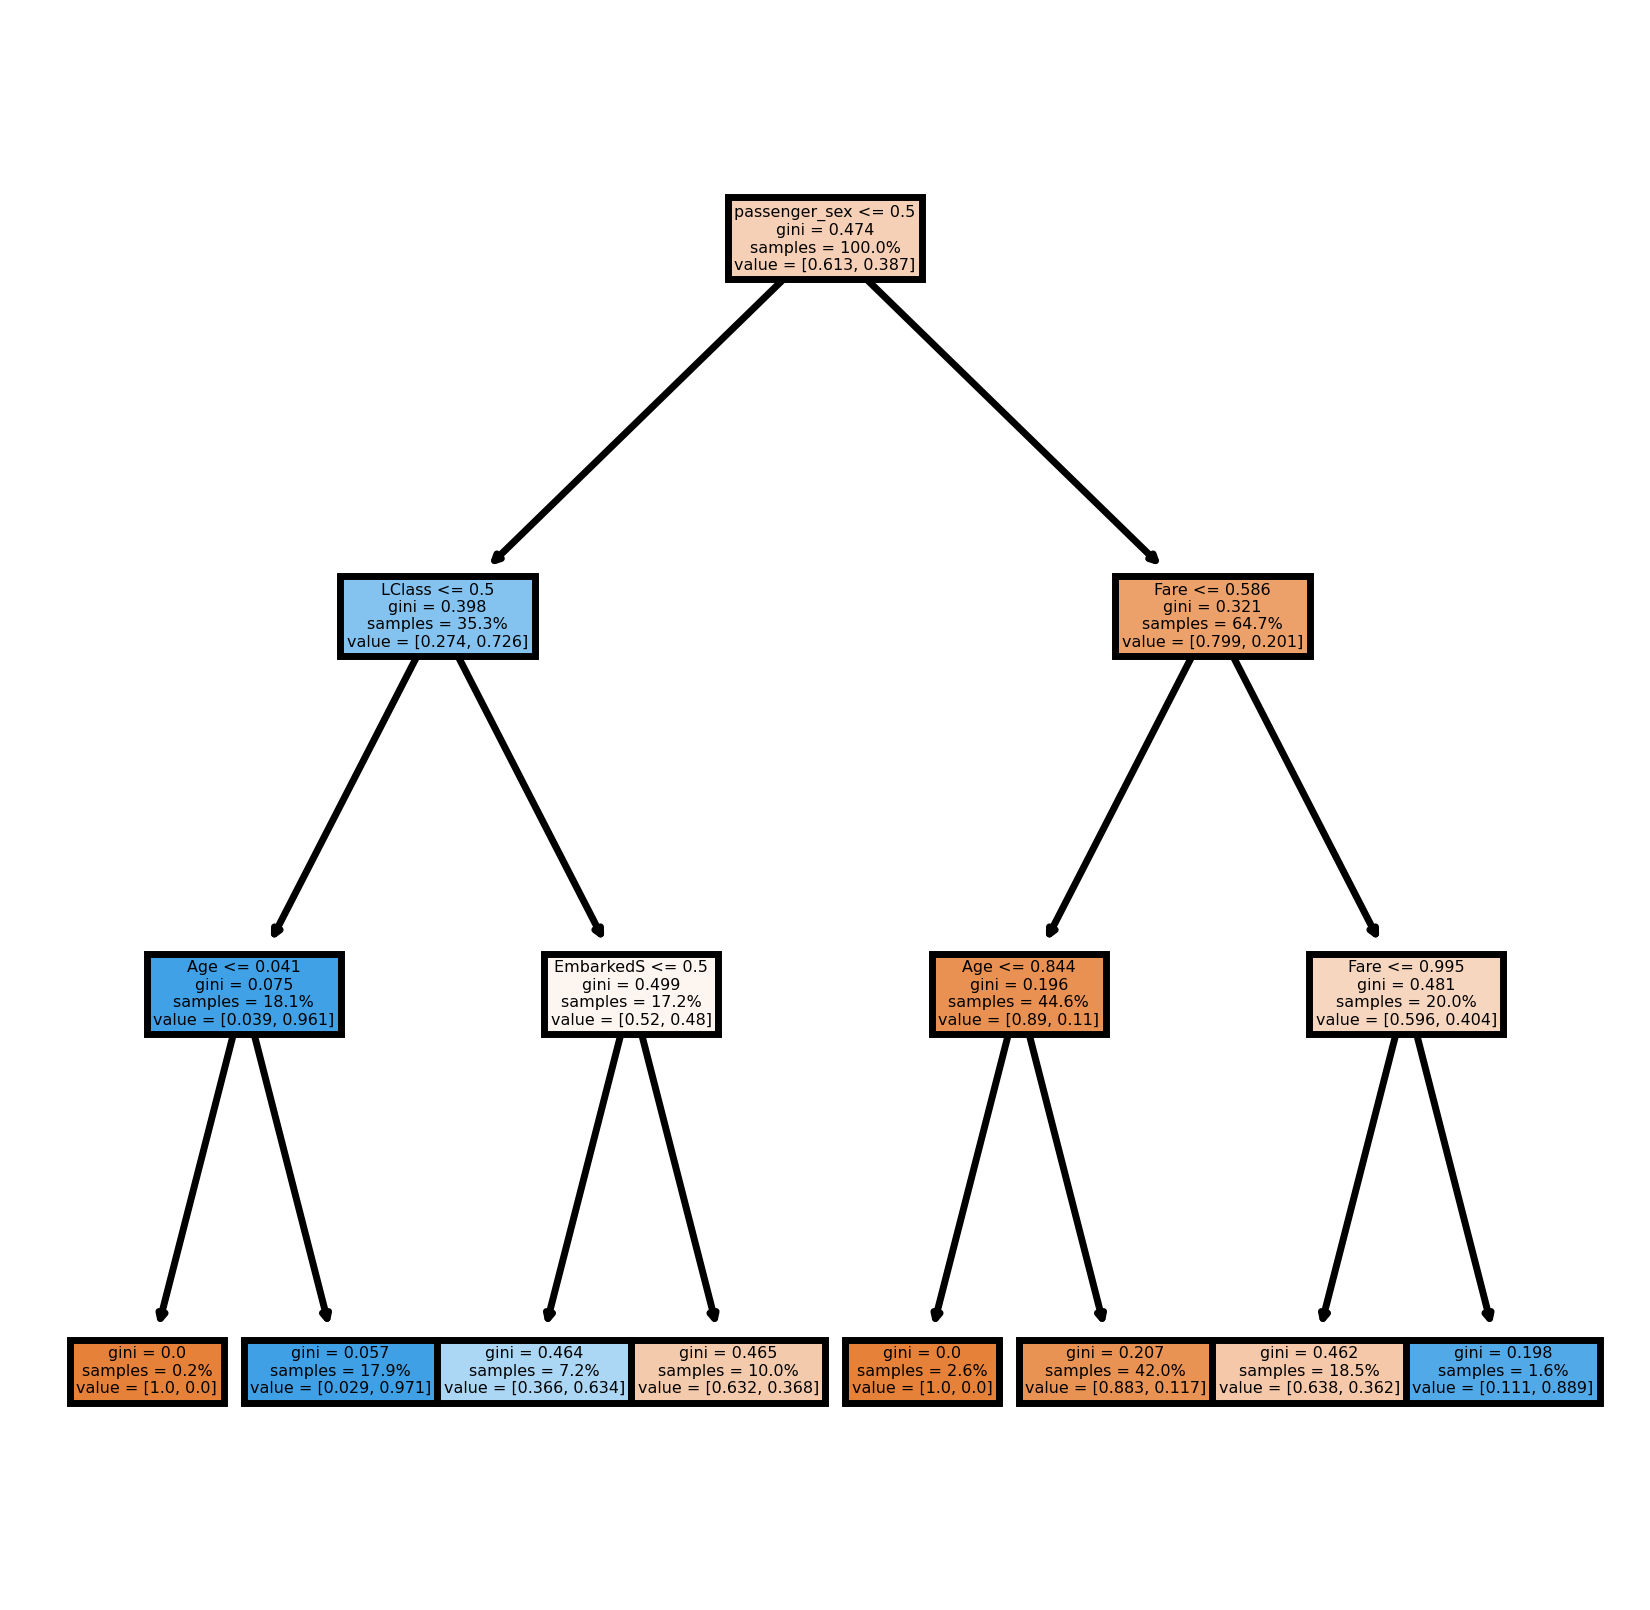

In [156]:
predecir(35)

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.0652336522323872
Probabilidad Naive Bayes 0: 6.336725202095463e-05
Probabilidad Naive Bayes 0: 9.629346404073182e-06
Árbol de decisiones (Grafo)


0

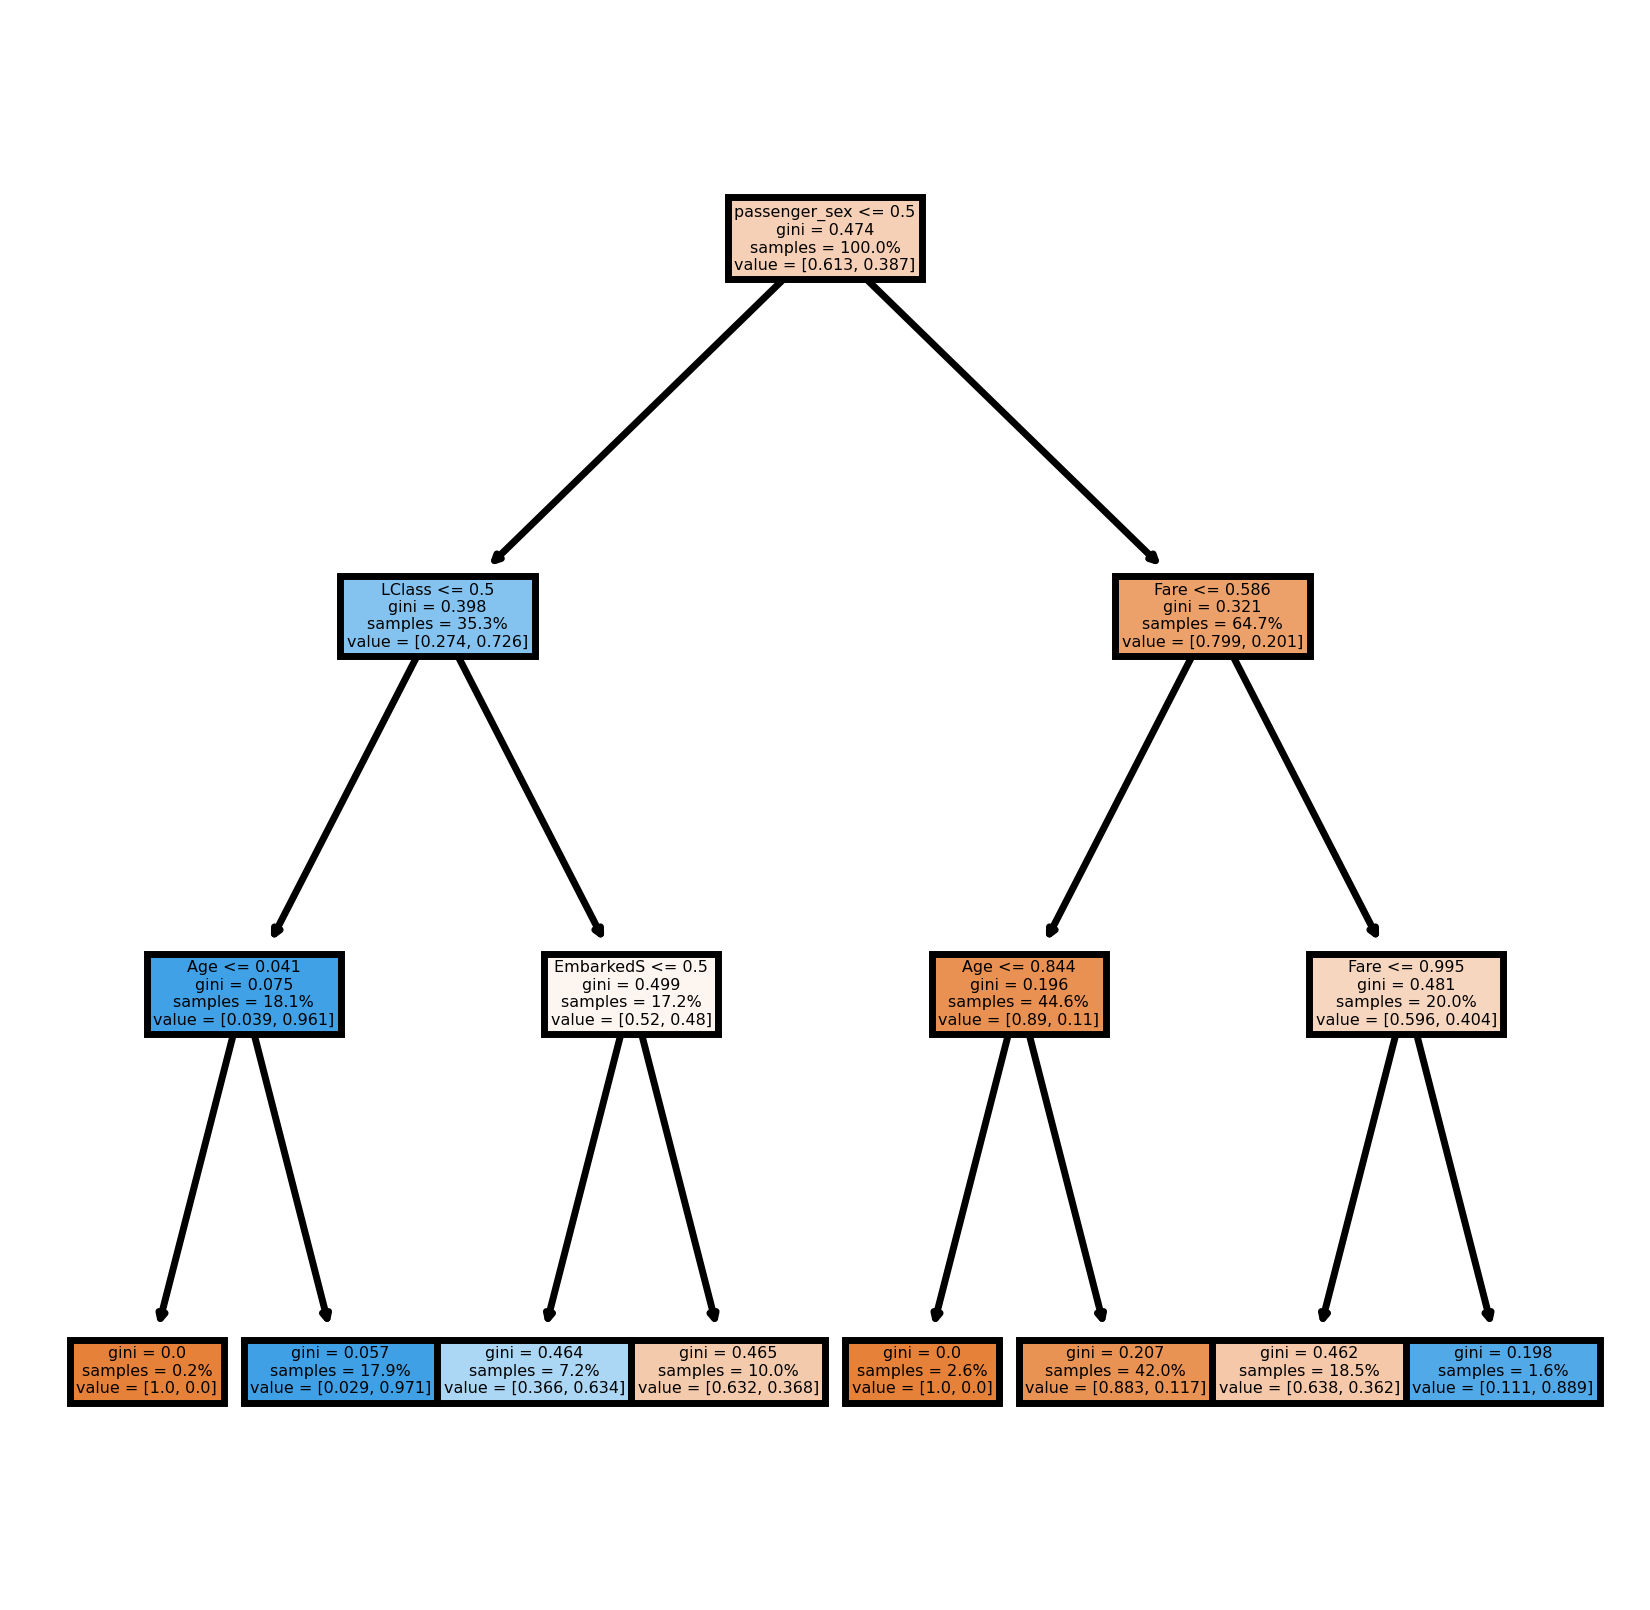

In [141]:
predecir(0)

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.09832340978364479
Probabilidad Naive Bayes 0: 0.00016216845581023978
Probabilidad Naive Bayes 0: 5.709672174832223e-05
Árbol de decisiones (Grafo)


0

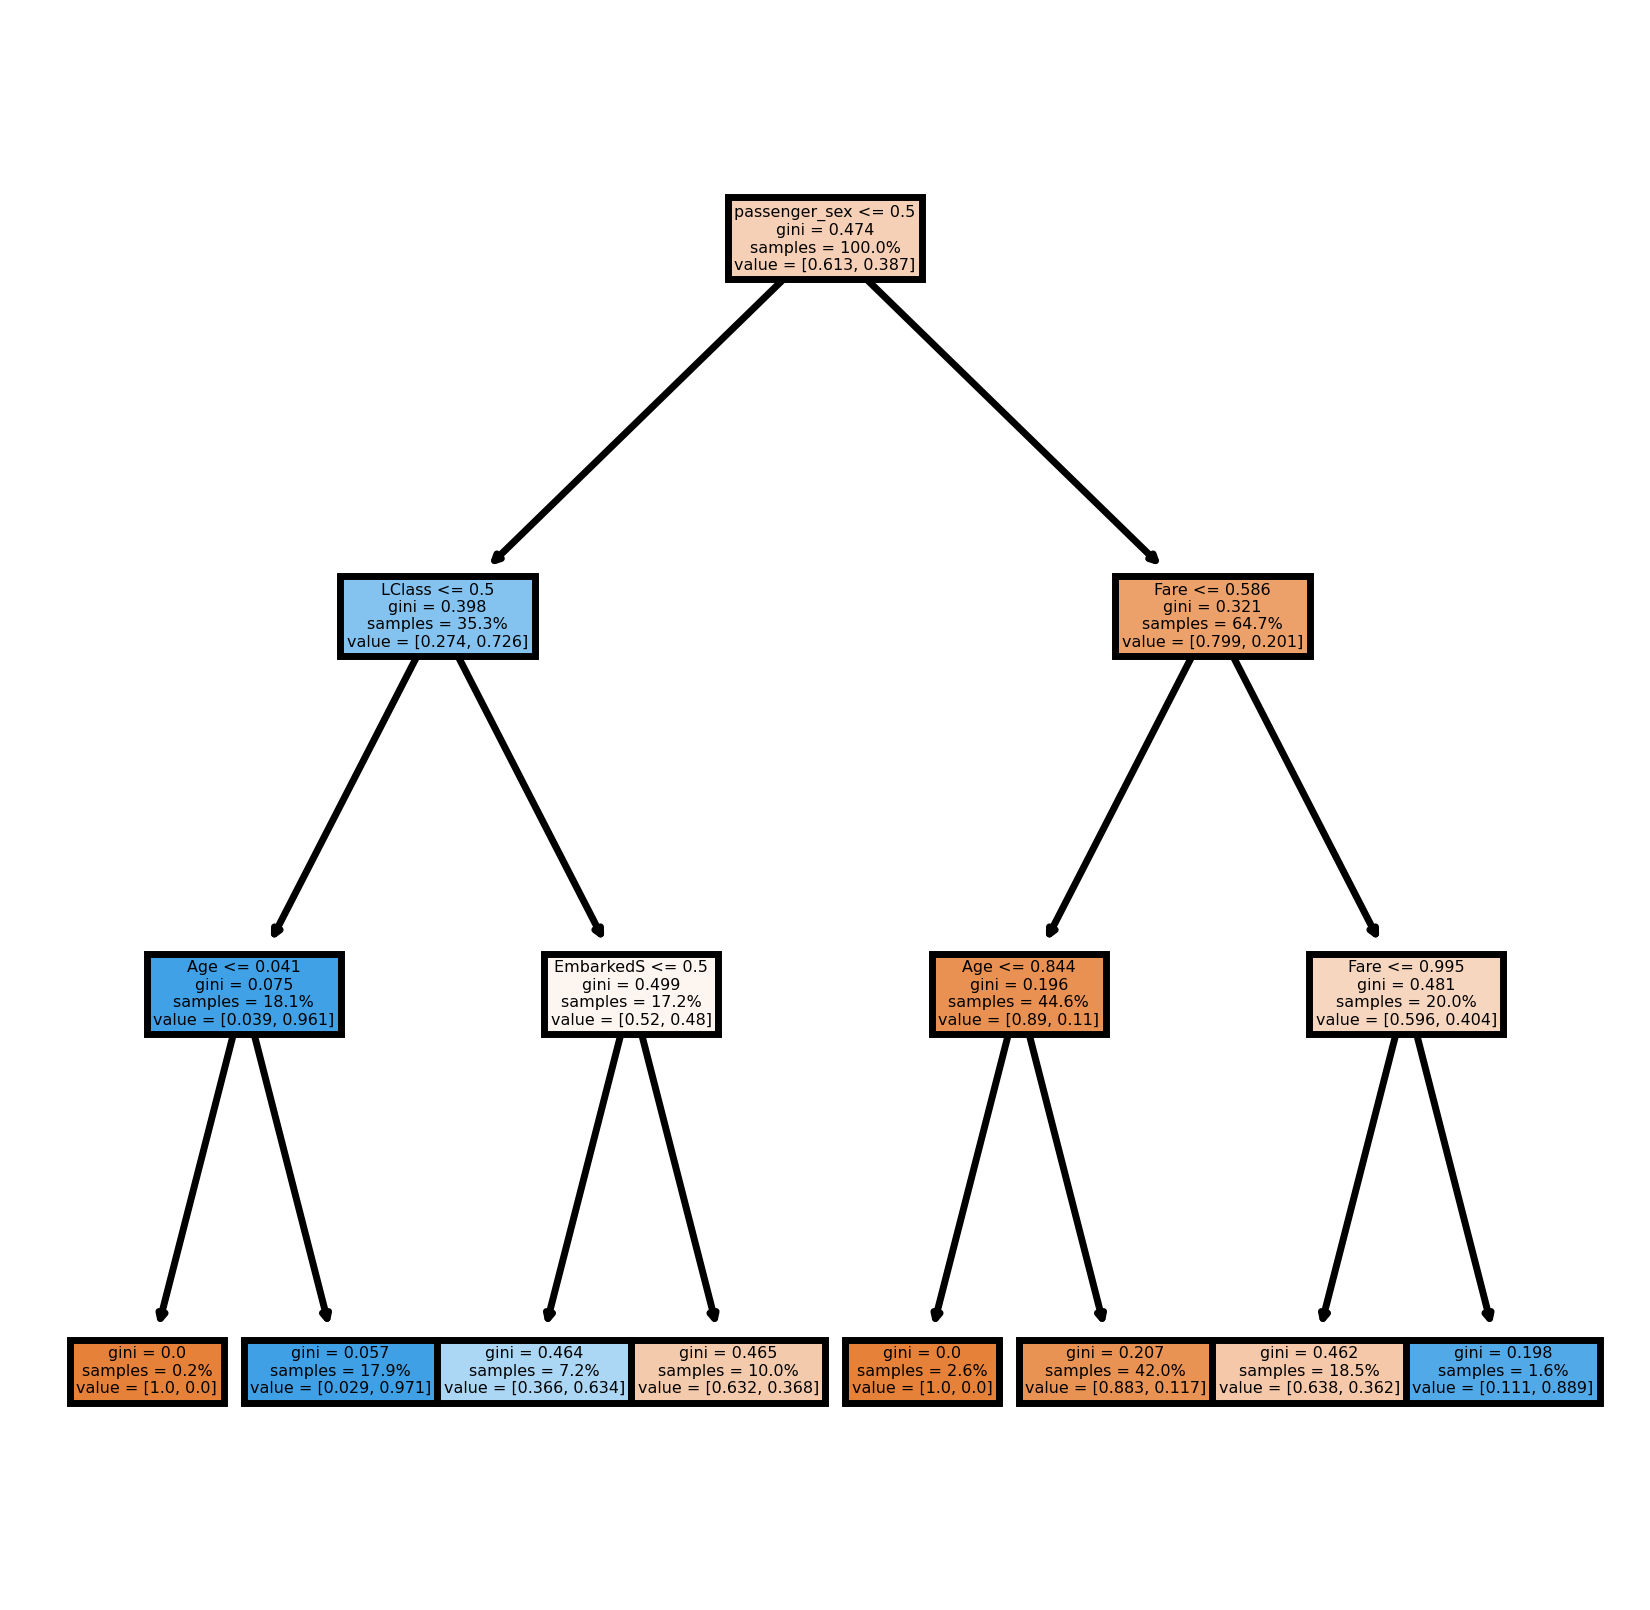

In [142]:
predecir(1)

---------Resumen de resultados--------------
Valor real: survived
Predicción: died
Probabilida (Regresión Logística): 0.4025798621801685
Probabilidad Naive Bayes 0: 3.3588736493499636e-07
Probabilidad Naive Bayes 0: 2.7224946537626726e-05
Árbol de decisiones (Grafo)


0

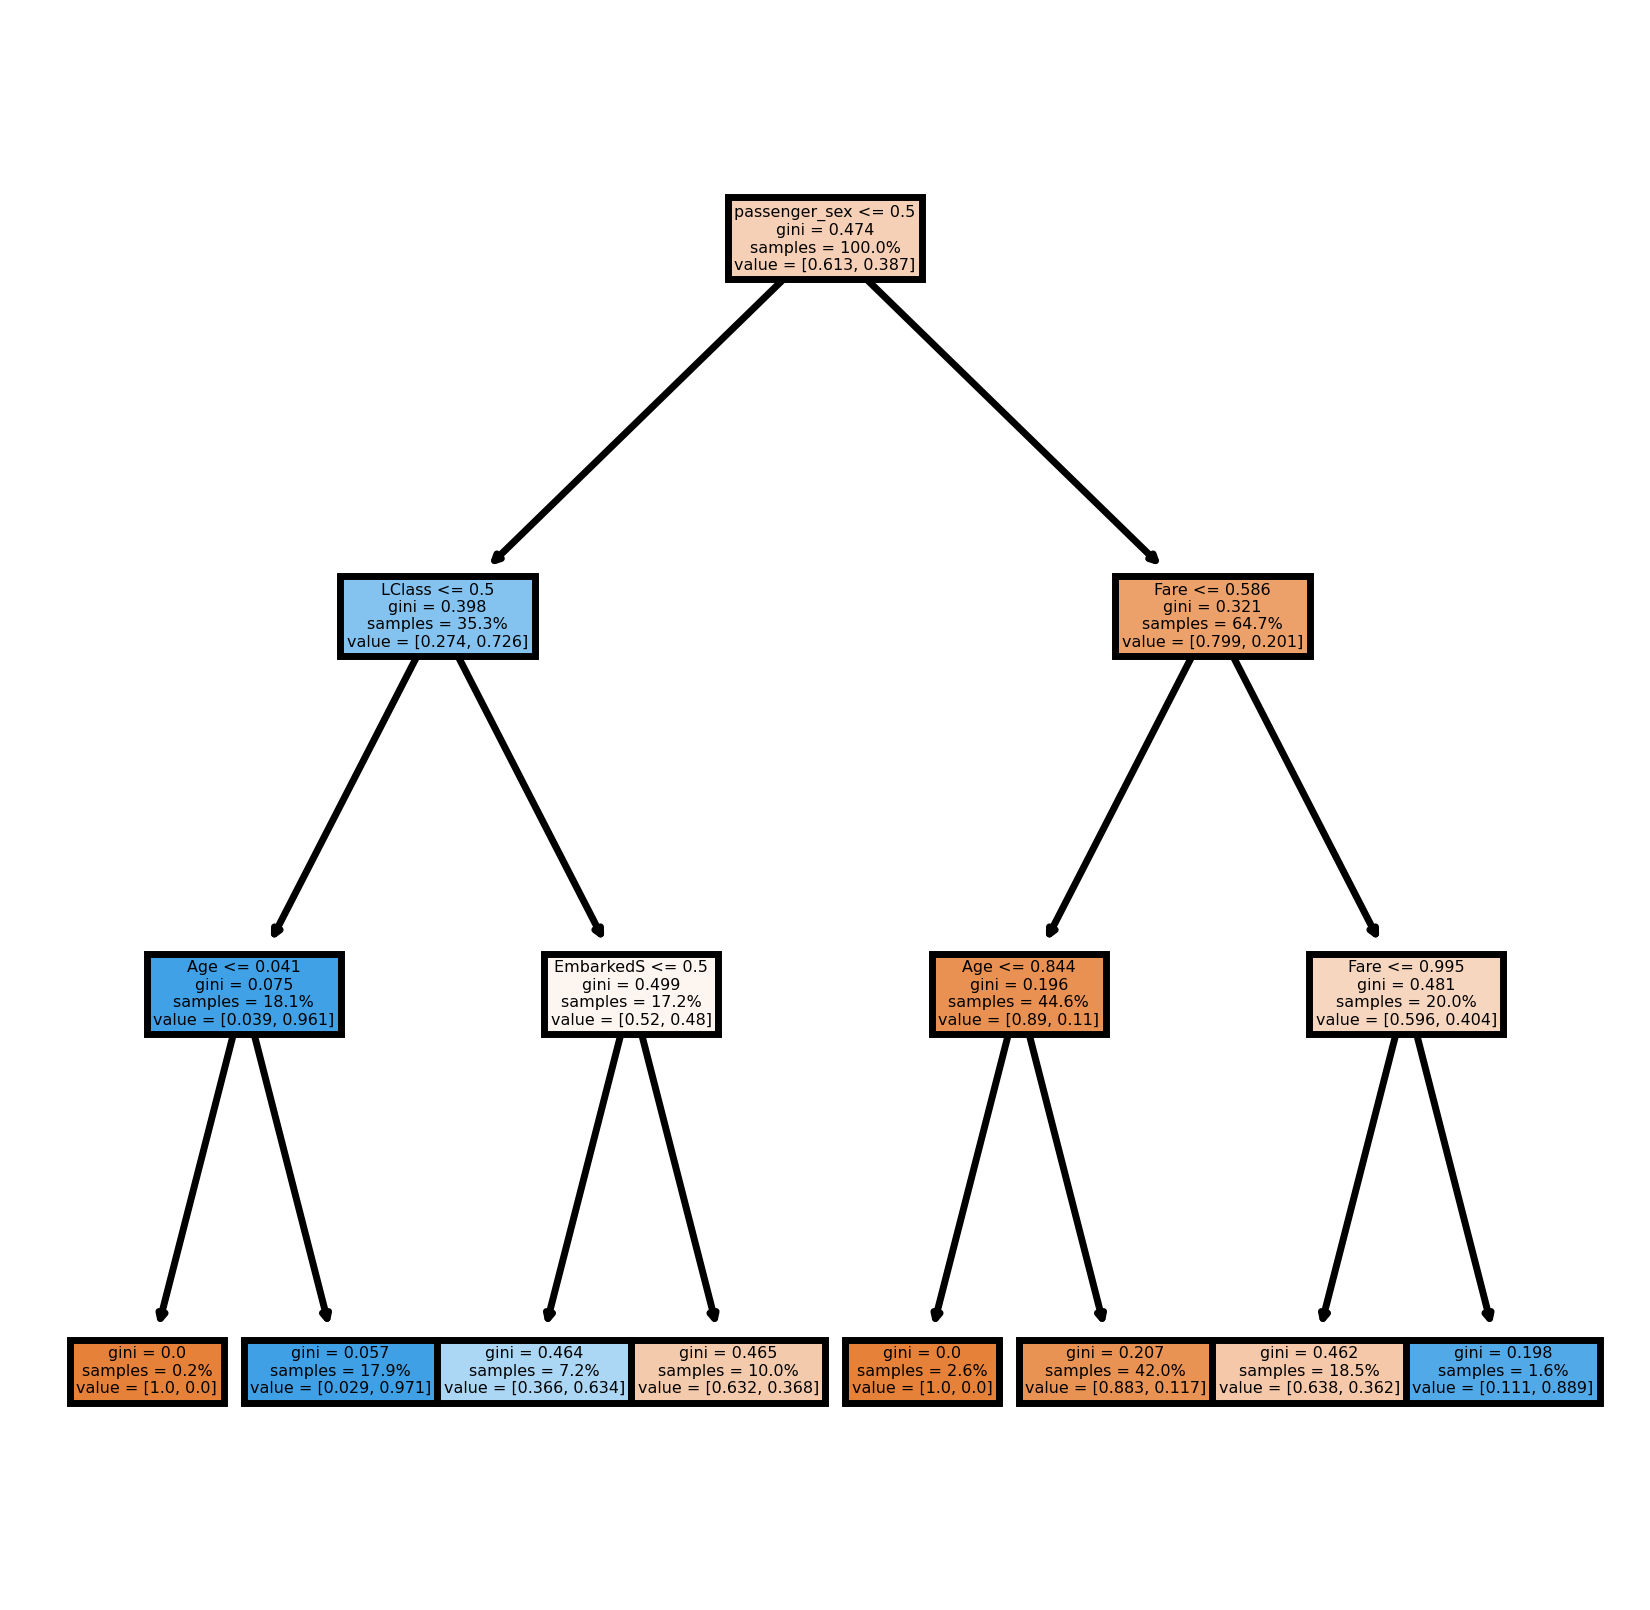

In [143]:
predecir(20)

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.1665309183910277
Probabilidad Naive Bayes 0: 8.237725282800282e-06
Probabilidad Naive Bayes 0: 0.00010658391078799341
Árbol de decisiones (Grafo)


0

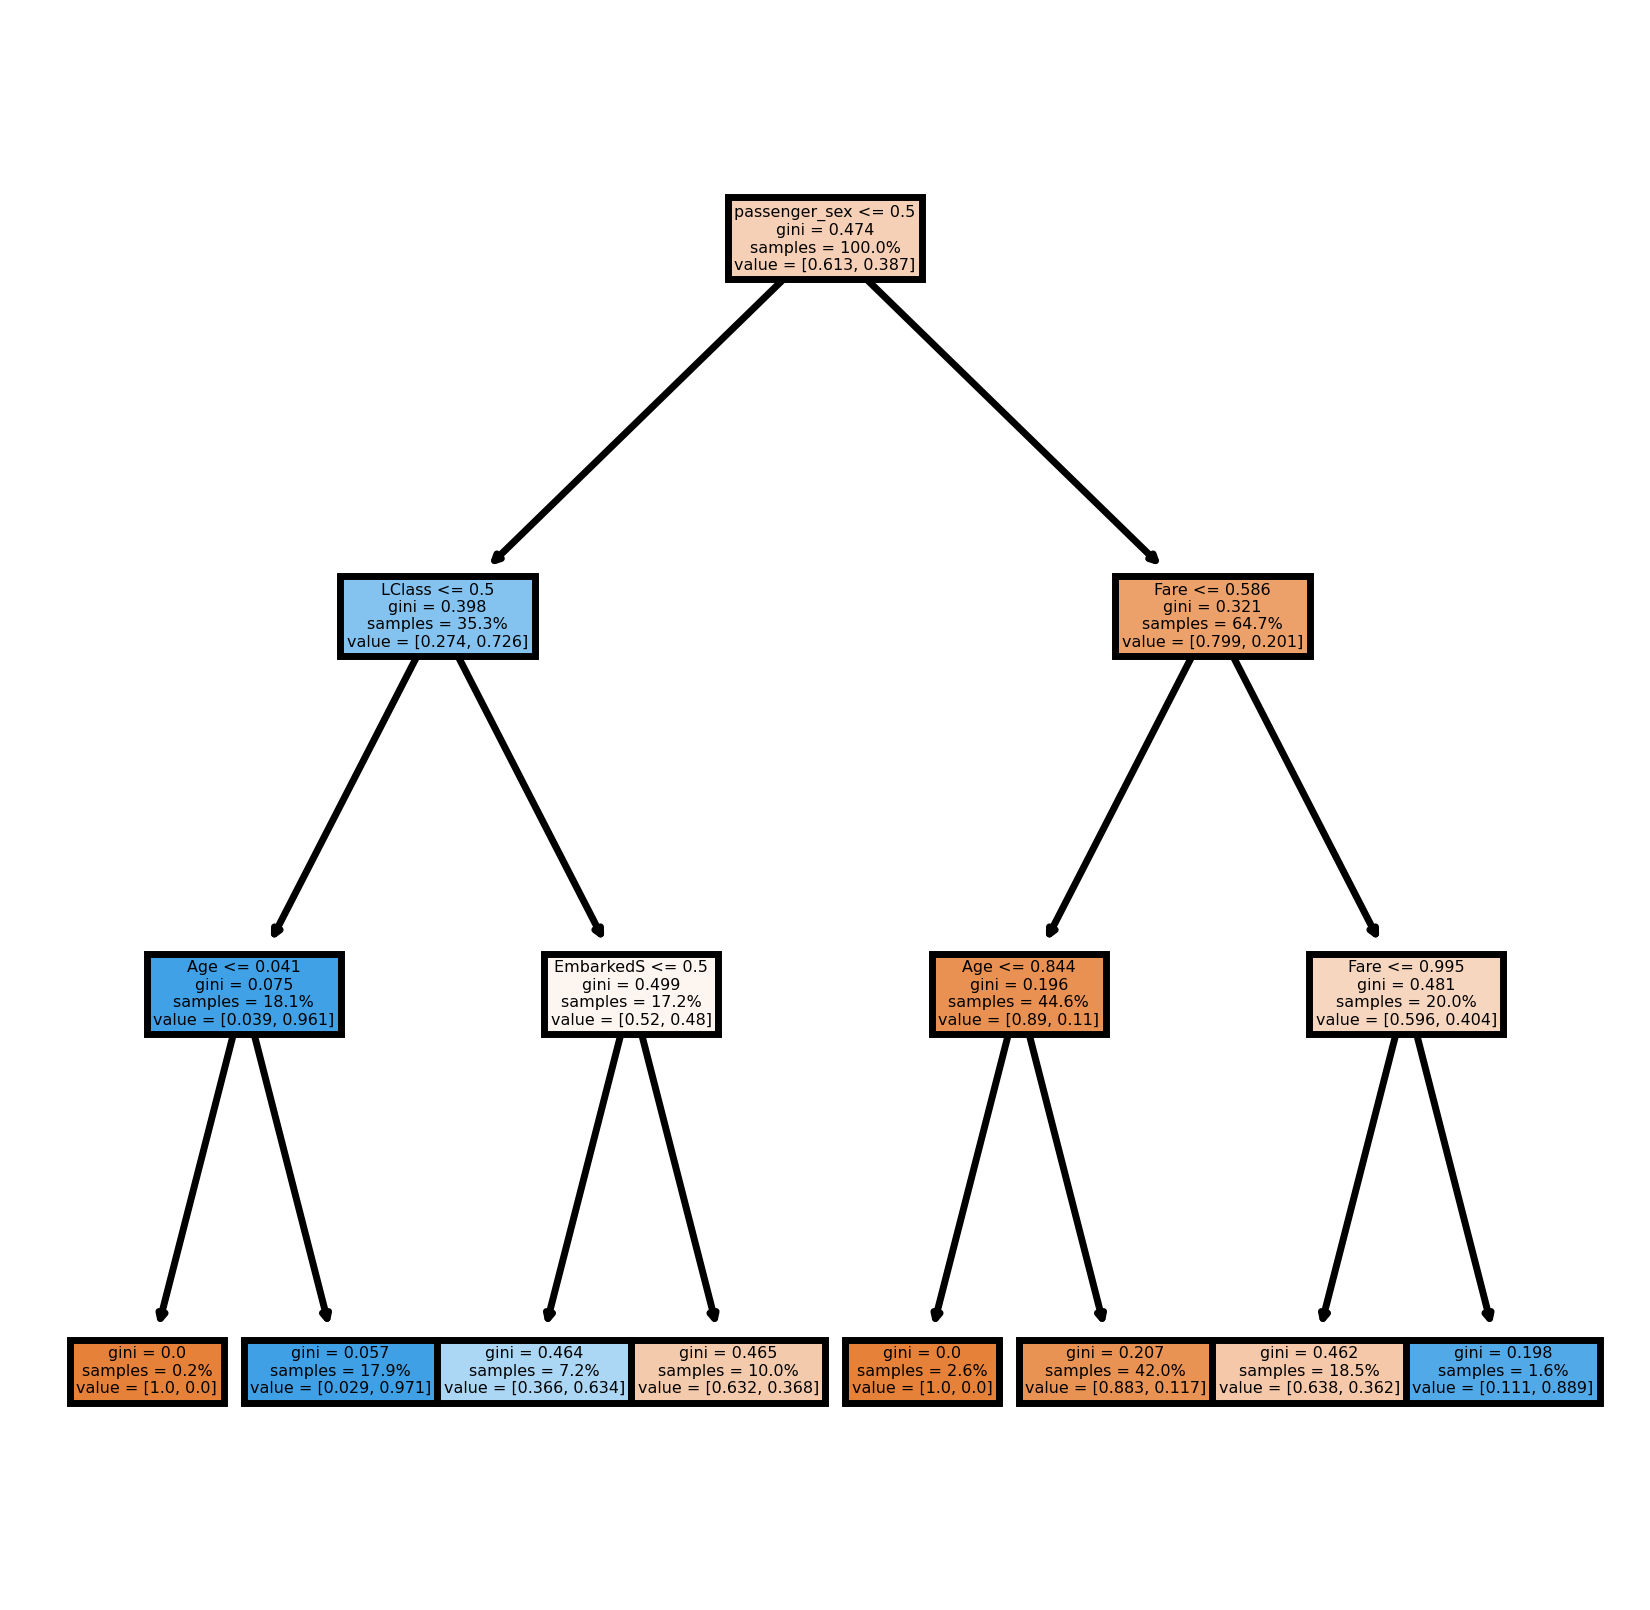

In [144]:
predecir(30)

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.06346935388204619
Probabilidad Naive Bayes 0: 5.4335805286895266e-05
Probabilidad Naive Bayes 0: 7.913681268775575e-06
Árbol de decisiones (Grafo)


0

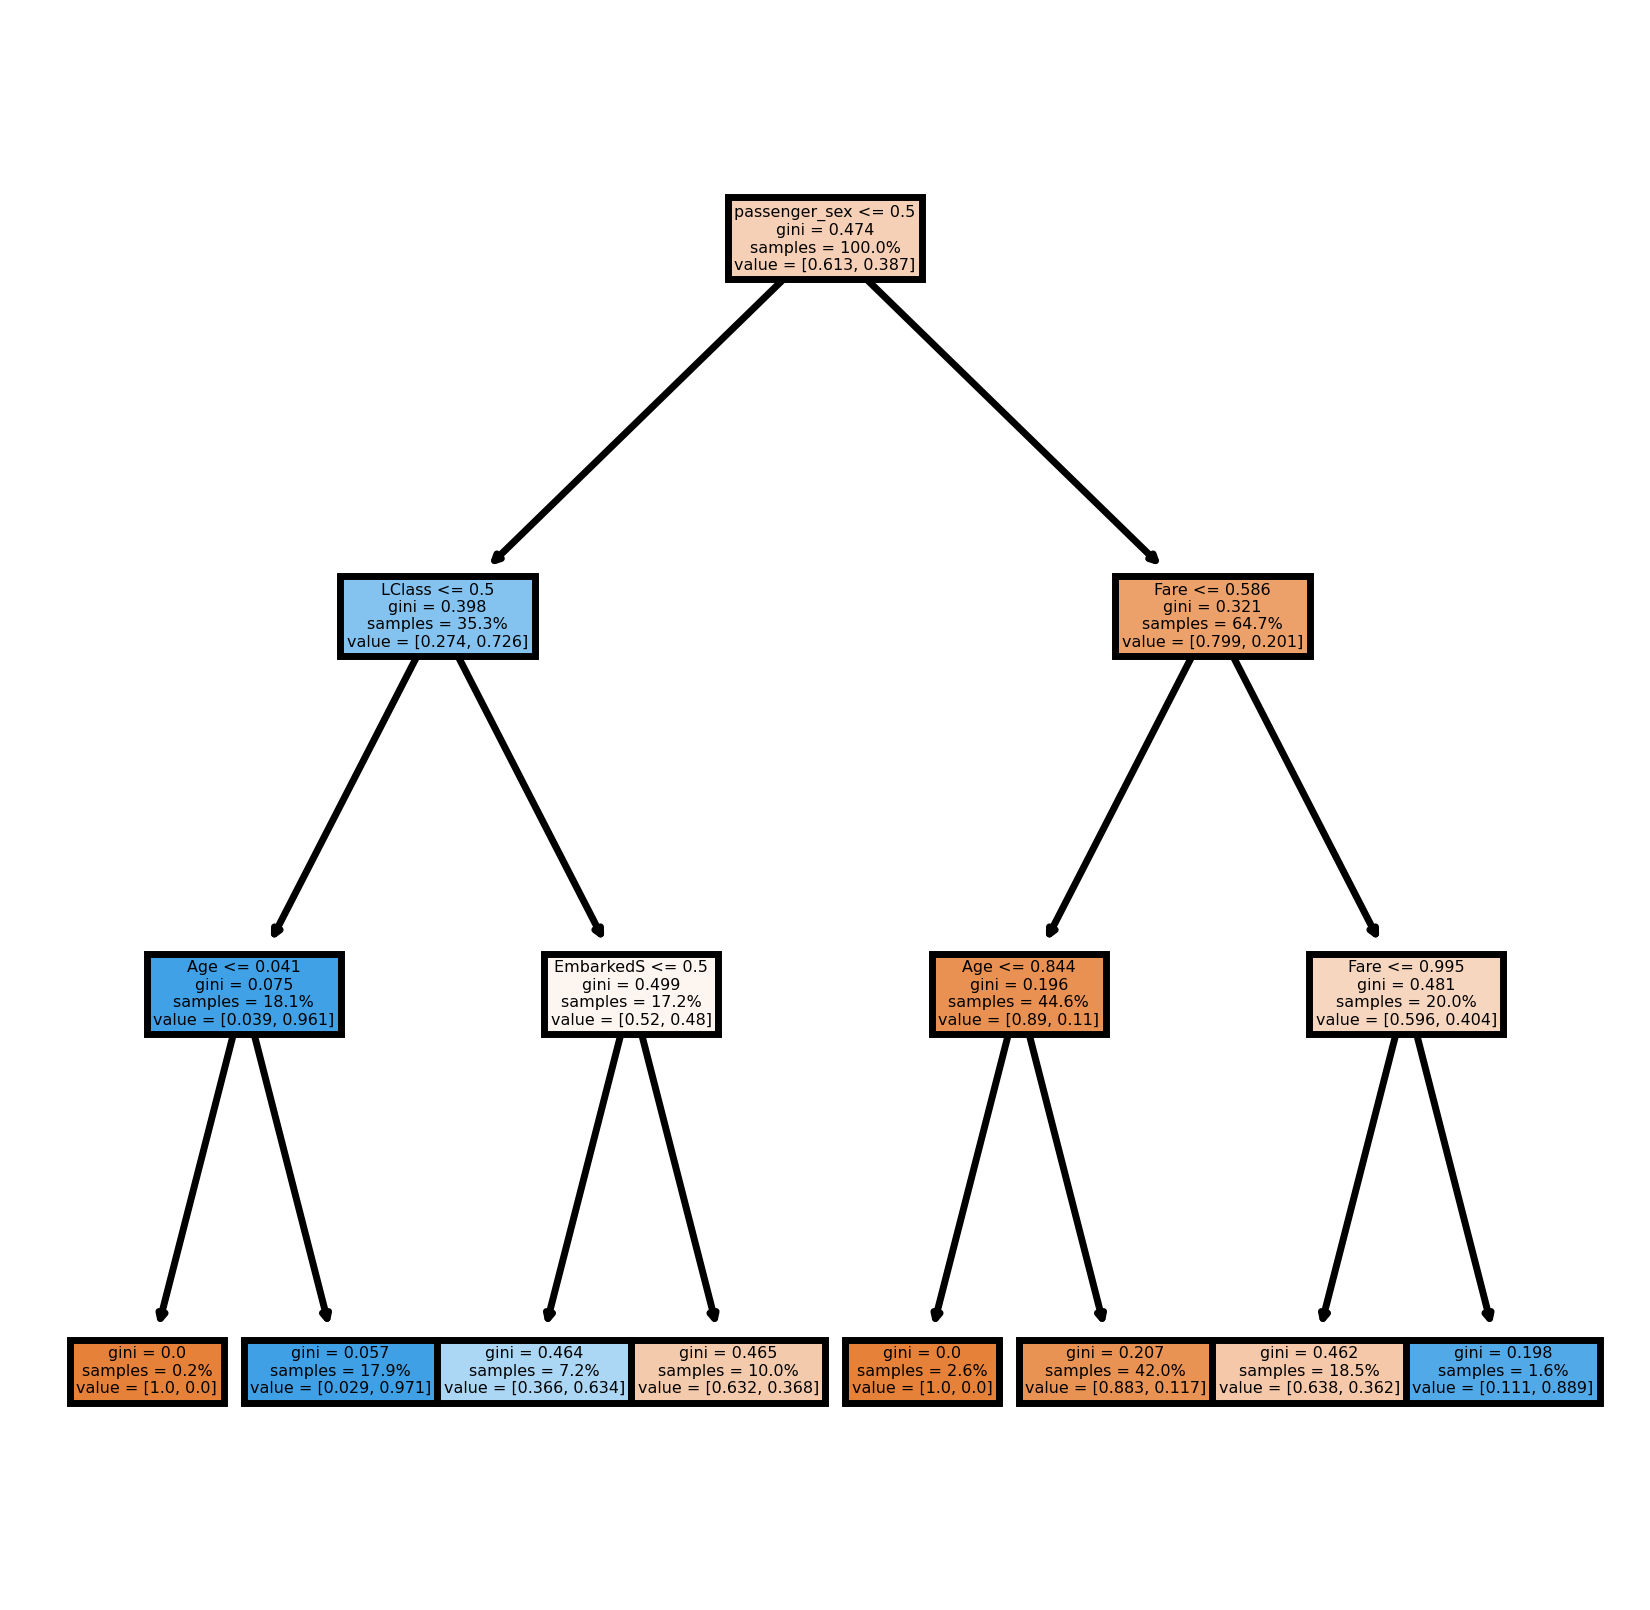

In [146]:
predecir(80)

---------Resumen de resultados--------------
Valor real: died
Predicción: died
Probabilida (Regresión Logística): 0.26192107607099446
Probabilidad Naive Bayes 0: 3.4964820617156976e-05
Probabilidad Naive Bayes 0: 2.4353709810729154e-05
Árbol de decisiones (Grafo)


0

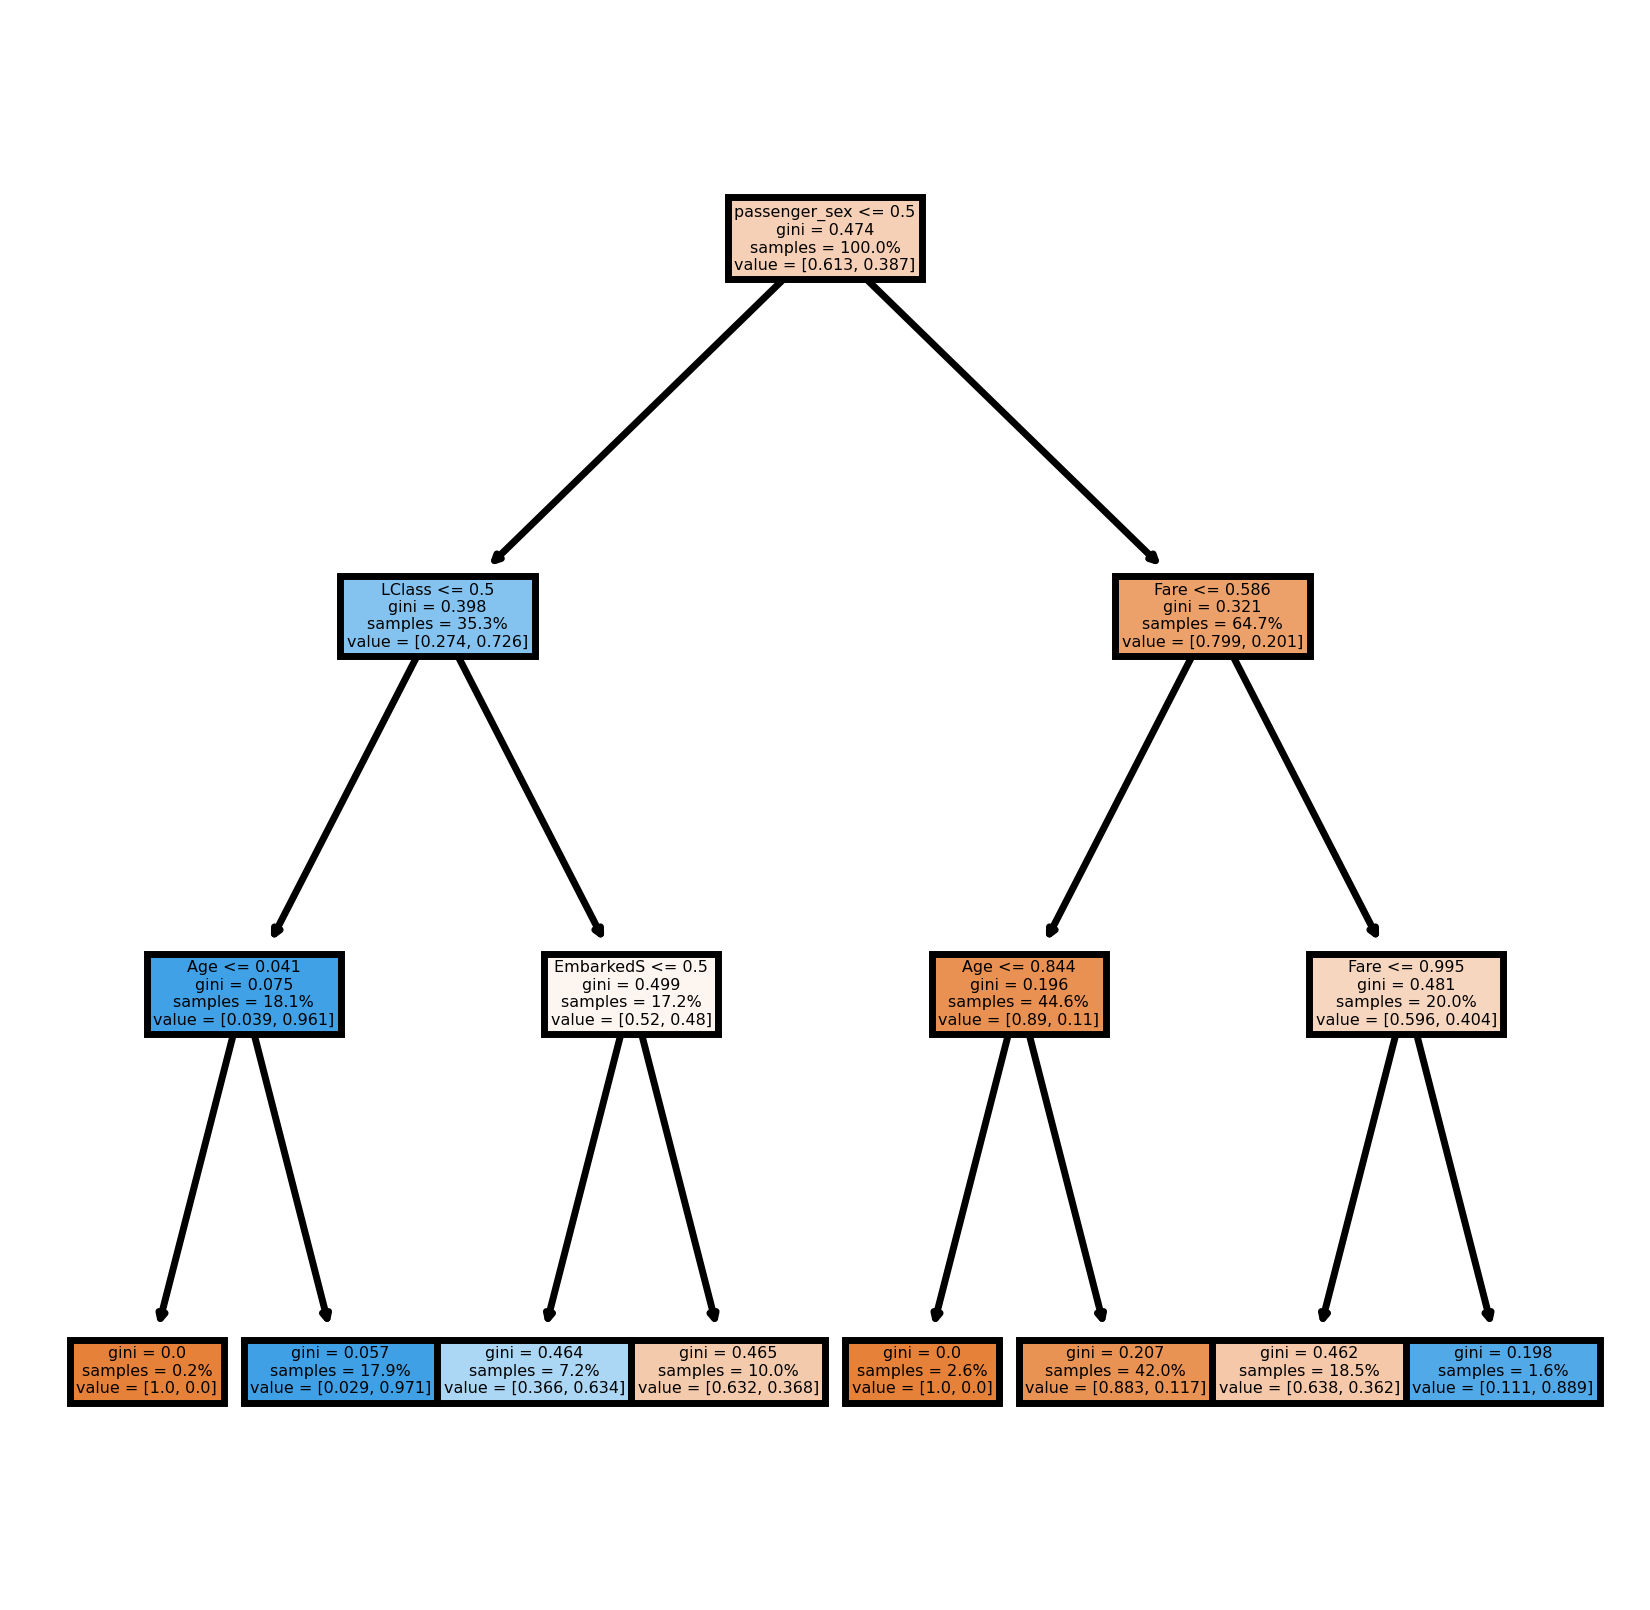

In [147]:
predecir(110)

---------Resumen de resultados--------------
Valor real: died
Predicción: survived
Probabilida (Regresión Logística): 0.6381226721115646
Probabilidad Naive Bayes 0: 4.98399177056517e-07
Probabilidad Naive Bayes 0: 3.240567009277269e-05
Árbol de decisiones (Grafo)


1

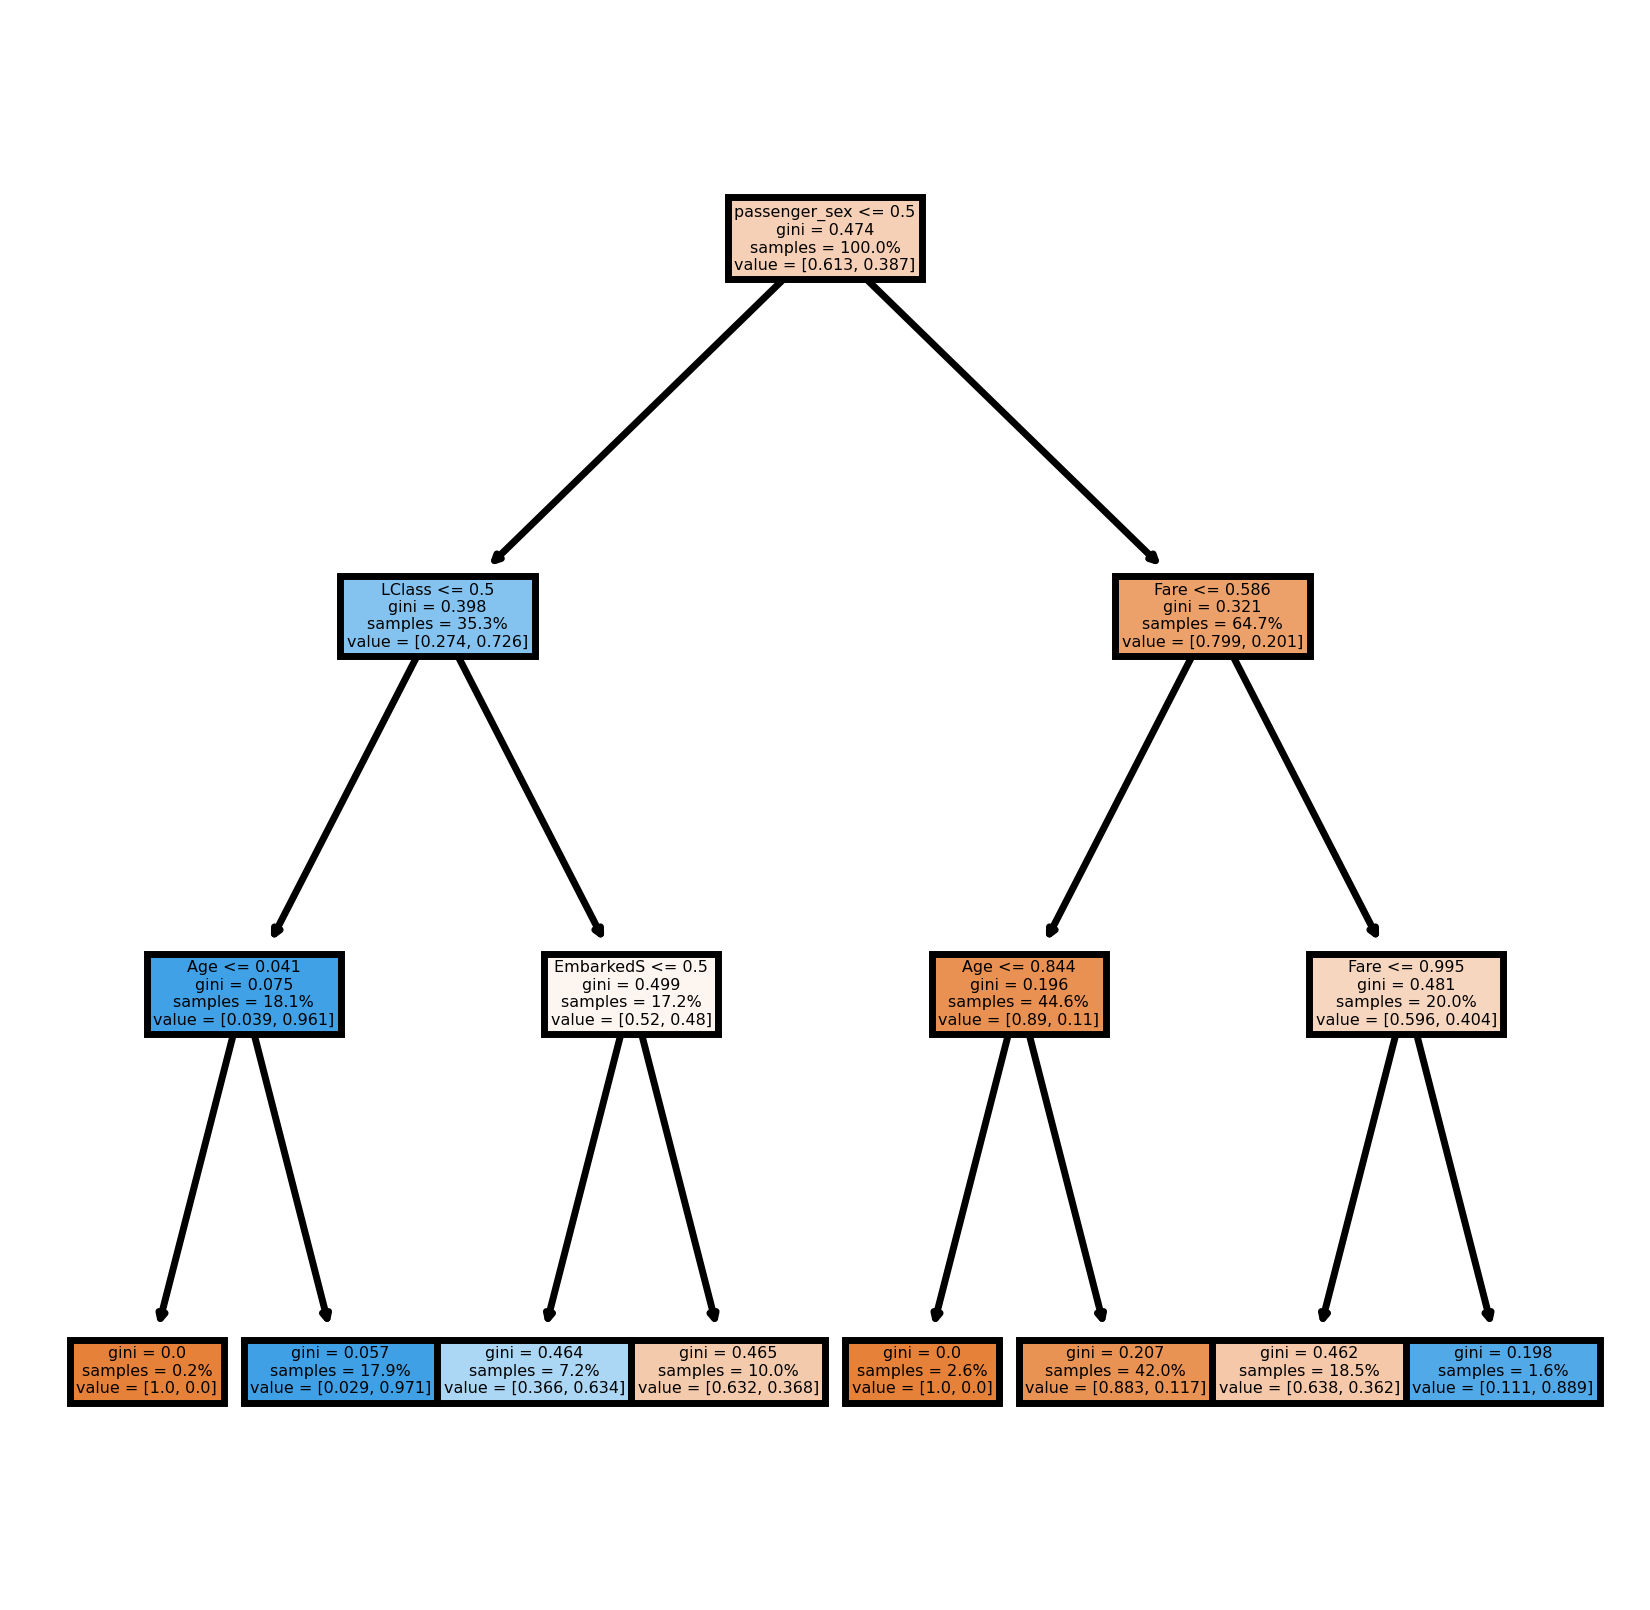

In [148]:
predecir(123)

---------Resumen de resultados--------------
Valor real: survived
Predicción: survived
Probabilida (Regresión Logística): 0.8984375051768931
Probabilidad Naive Bayes 0: 1.2465632514707428e-08
Probabilidad Naive Bayes 0: 5.2681057856327215e-06
Árbol de decisiones (Grafo)


1

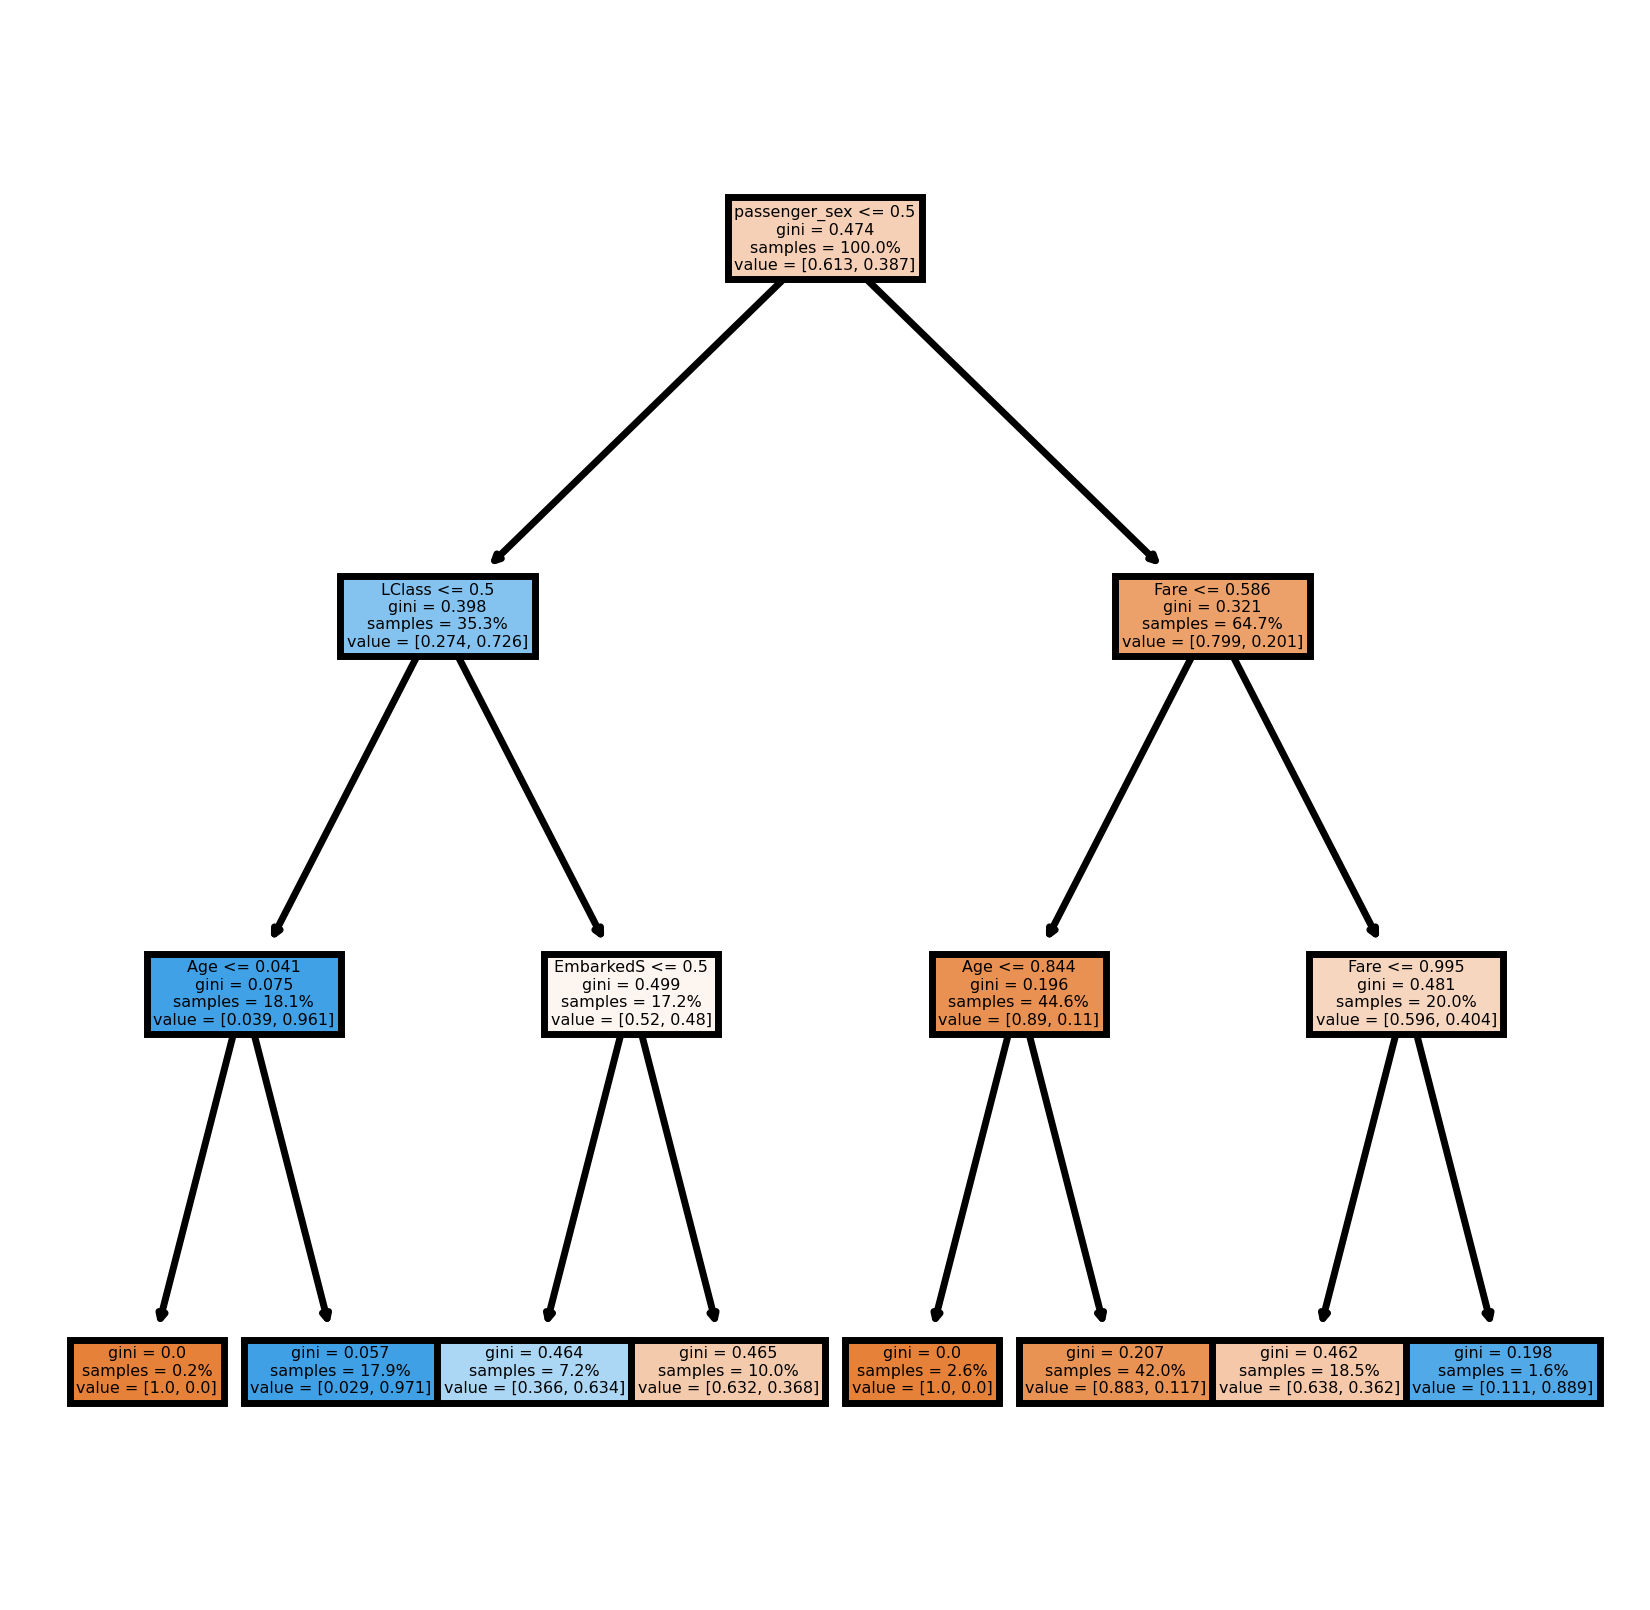

In [149]:
predecir(142)

---------Resumen de resultados--------------
Valor real: survived
Predicción: survived
Probabilida (Regresión Logística): 0.9291804565959203
Probabilidad Naive Bayes 0: 1.2463650829043544e-06
Probabilidad Naive Bayes 0: 7.943365441374234e-05
Árbol de decisiones (Grafo)


1

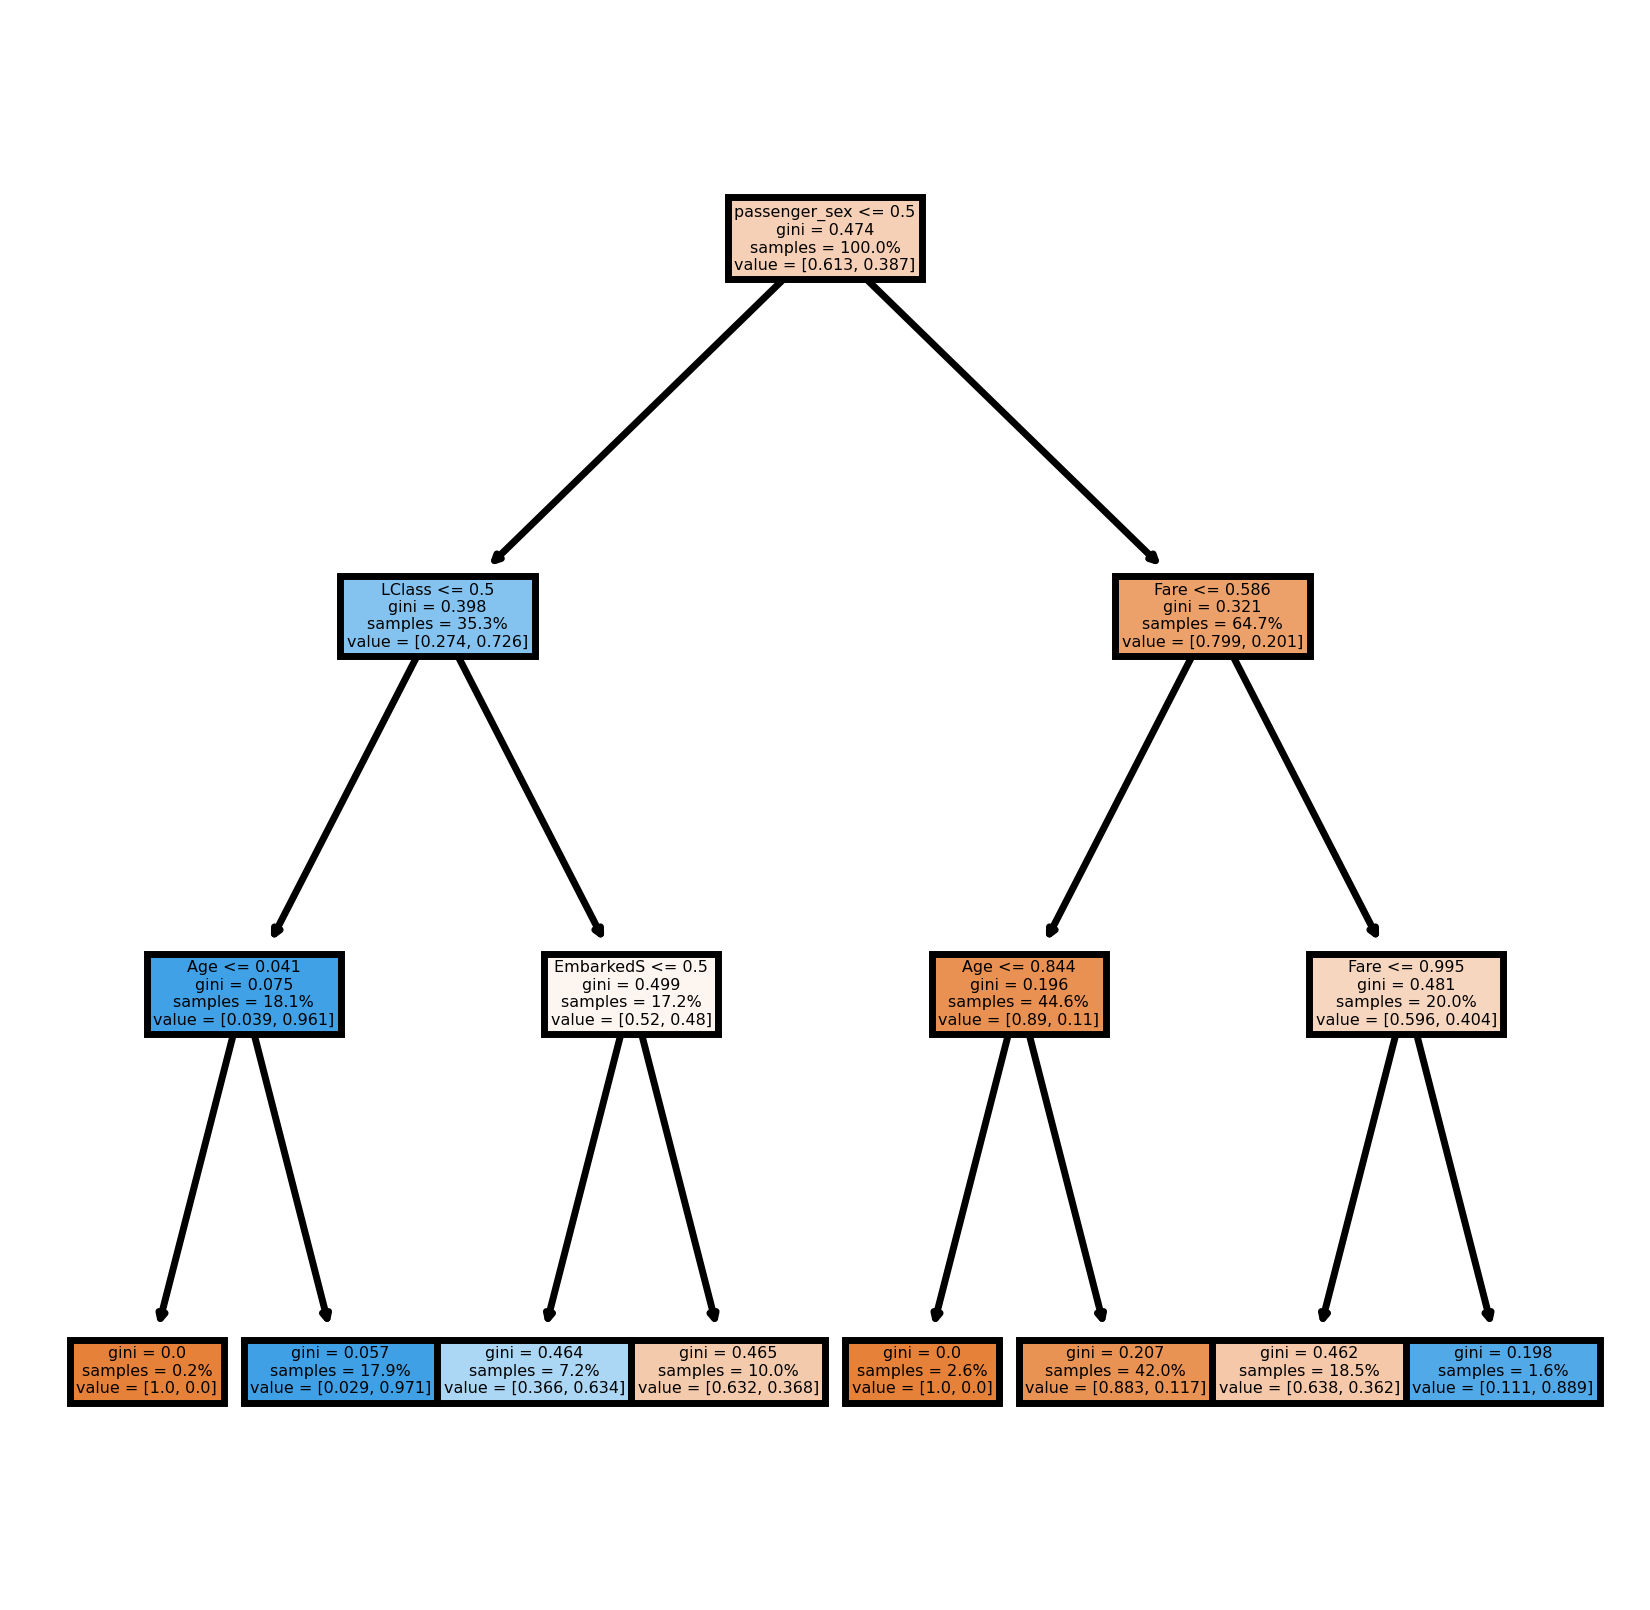

In [150]:
predecir(156)